# Analysis of the popular music of the last 55 years

### Data Wrangling

##### Imports - API settings - Constants definition

In [64]:
from math import *
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.stats as stats

# EchoNest API
from pyechonest import config
from pyechonest import song
from pyechonest import artist

# LastFM API
import pylast

# Geopy
from geopy.geocoders import Nominatim

# Functions used in this notebook
import dataStoryFunctions as dsf

# some nicer colors
COLORS = dsf.create_tableau20_RGB_code()

In [2]:
# Loads the credentials from the yaml file
secrets = dsf.load_secrets()

# Set ECHO_NEST_API_KEY value
config.ECHO_NEST_API_KEY = secrets["echonest_api_key"]

# Set LastFM API_KEY and API_SECRET
# Obtain yours from http://www.last.fm/api/account for Last.fm
API_KEY = secrets["lastfm_api_key"]
API_SECRET = secrets["lastfm_api_secret"]

# In order to perform a write operation you need to authenticate yourself
username = secrets["lastfm_username"]
password_hash = pylast.md5(secrets["lastfm_password_hash"])

last_fm_network = pylast.LastFMNetwork(api_key = API_KEY, api_secret =
    API_SECRET, username = username, password_hash = password_hash)

In [3]:
# Define the starting and ending years 
start_year = 1960
end_year = 2015

##### Original dataframe creation

The next steps take a lot of time to complete and have been done in the data processing and cleaning process.

The final dataframe has been completed manually for the remaining missing data.

In [4]:
# Creation of the global dataframe

# billboard_df = dsf.create_billboard_df_from_CSV(start_year, years)
# s = billboard_df['Title'].str.split('" / "').apply(pd.Series, 1).stack()
# s.index = s.index.droplevel(-1)
# s.name = 'Title'
# del billboard_df['Title']
# billboard_df = billboard_df.join(s)
# billboard_df = billboard_df[['Num', 'Artist(s)', 'Title', 'Year']] 

In [5]:
# Addition of new characteristics to the dataframe (artist location, audio summary...)

# billboard_df_final = dsf.add_songs_characteristics_to_df(billboard_df, 
#                                                        'CSV_data/billboard_df-final.csv')

The final dataframe has been built using the previous commands and completed manually in Excel. Everything has been saved in a CSV file which will be loaded in a pandas dataframe.

In [8]:
#billboard_df_final = pd.read_csv('CSV_data/billboard_df-final.csv', sep=';')
#del billboard_df_final['Colonne1']

The country of origin of each artist is added at the end of every row of the dataframe. This will be used in one of the charts in the study.

In [10]:
billboard_df_final = dsf.add_track_country_of_origin_to_DF(billboard_df_final)

As the data as already been generated, you can skip all the previous step and directly build the final dataframe from the CSV file.

In [11]:
#billboard_df_final = pd.read_csv('CSV_data/billboard_df-final.csv')
#del billboard_df_final['Unnamed: 0']

##### Number of songs by artists in the Billboard Hot 100 year-end

The methodology used to create this dataframe is explained in the article related to the project.

In [56]:
unique_artist_df = dsf.create_entries_by_unique_artist(billboard_df_final,
                                                       start_year, end_year)

Finally, we add one last feature to the dataframe groupping the number of tracks by artist. This feature is the dominance of the artist on given period. This is calculated by summing the number of tracks ranked in the charts for one particular artist during n years and dividing that number by the total number of tracks in the Billboard Hot 100 during those n years.

In this study we have chosen to use rolling periods of 3 years.

In [57]:
unique_artist_df = dsf.get_most_dominant_artist_per_years(unique_artist_df, start_year,
                                                          end_year, 3, 1)

For visualization purposes, we add an image of the artist to the dataframe (this is a url returned by the last fm API).

In [29]:
unique_artist_df = dsf.add_image_url_to_artist_count_df(unique_artist_df, last_fm_network)

2 additional features are also added to the previous dataframe:
- the artist 'hotttnesss'
- the artist 'familiarity'

In [32]:
unique_artist_df = dsf.add_items_to_billboard_df_artist_count(unique_artist_df,
                                                              ["familiarity", "hotttnesss"])

As the data as already been generated, you can skip all the previous step and directly build the final artist count dataframe from the CSV file.

In [13]:
#unique_artist_df = pd.read_csv('CSV_data/billboard_df-artist_count.csv', sep=';')
#del unique_artist_df['Unnamed: 0']

##### Linear Regression

To try to analyze the relation that exists between the number of tracks in the Billboard Hot 100 and the number of years of presence in the charts for each artist, we are going to use a linear regression. We will only consider the top 100 performers in the regression.

To do that we need to import scikit-learn and numpy.

In [12]:
import numpy as np
from sklearn import linear_model

In [45]:
artists_top_100 = unique_artist_df[:101]
artists_X_train = artists_top_100[['Counts']].values
artists_Y_train = artists_top_100[['Years of presence']].values

In [46]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [50]:
# Train the model using the training sets
regr.fit(artists_X_train, artists_Y_train)

# The coefficients
print 'Coefficients: \n', regr.coef_
print 'Intercept: \n', regr.intercept_

Coefficients: 
[[ 0.31592062]]
Intercept: 
[ 3.32566998]


##### Study of the acoustic attributes of the dataset

While building our dataset (`bilboard_df_final`) in the first step of the project, a lot of acoustic metrics have been added to each song. These different features give interesting additional details about the tracks.

I am particularly interested in one of them, which is the **valence** of each song. In the following steps this feature will be isolated and a statistical analysis will be performed to understand better what is the impact of this characteristic.

In [160]:
valence_cleaned = billboard_df_final["valence"].dropna()

Let's first look at the distribution of the valence data:

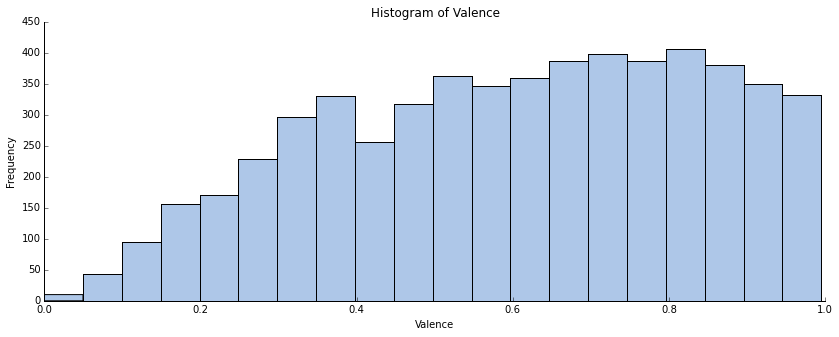

In [161]:
# Plot
plt.figure(figsize=(14, 5))
plt.xlabel('Valence')
plt.ylabel('Frequency')
plt.title('Histogram of Valence')
plt.grid(False)

# Remove the plot frame lines
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Histogram of the valence data
n, bins, patches = plt.hist(valence_cleaned.values, normed = False, color = COLORS[1], bins = 20)

plt.show()

The distribution does not seem to be normal. We observe a stage for 0.6 <= valence <= 0.85. The population presents less variance than a normal distribution. To illustrate those words, we will use a probability plot:

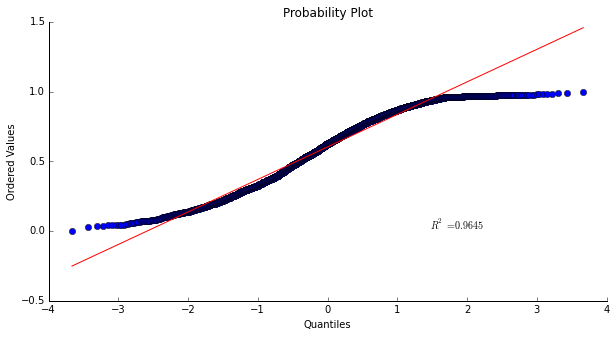

In [162]:
# Plot
plt.figure(figsize=(10, 5))
plt.grid(False)

# Remove the plot frame lines
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Probability plot
res = stats.probplot(valence_cleaned, dist = "norm", plot = plt)

plt.show()

This S shaped-curve indicates shorter than normal tails, i.e. less variance than expected. This confirms that the valence of the tracks is not normally distributed.

Using the `describe` command, we are going to plot some interesting statistic figures about the valence data:

In [163]:
valence_cleaned.describe()

count    5608.000000
mean        0.603195
std         0.237206
min         0.000000
25%         0.413064
50%         0.624989
75%         0.803726
max         0.994769
Name: valence, dtype: float64

As a result, we have a mean value of approximatively 0.6 for the valence. Plus, as the median is equal to 0.625, there are as many tracks having a valence included between 0 and 0.625 and tracks having a valence included between 0.625 and 1. This means that globally the songs  of the *Billboard* Hot 100 sound **positive**.

Is it the same thing for each decade?

In [168]:
reload(dsf)

<module 'dataStoryFunctions' from 'dataStoryFunctions.pyc'>

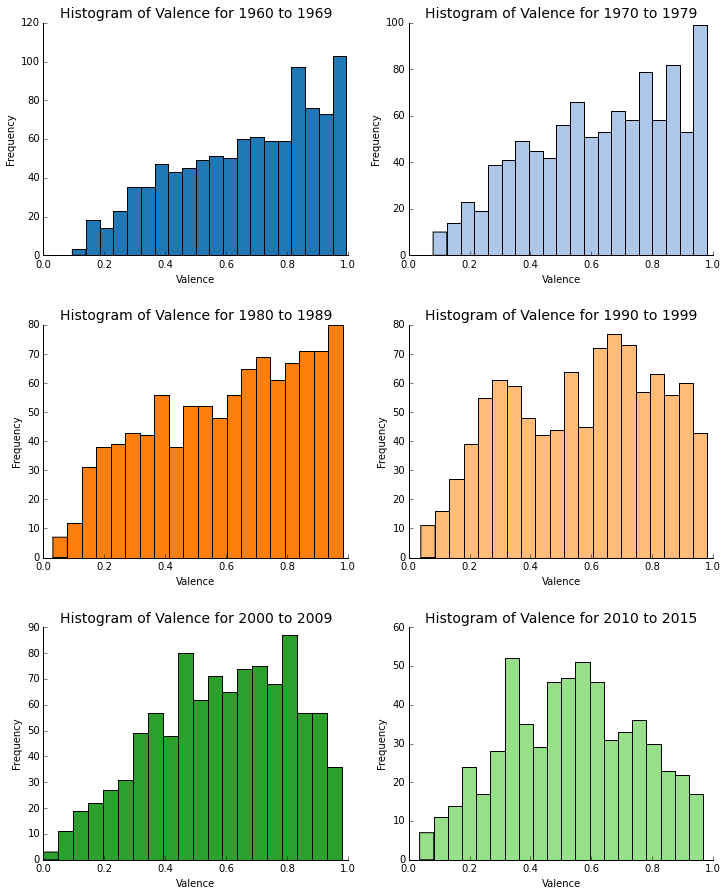

In [154]:
dsf.create_valence_histogram_per_decade(billboard_df_final)

In [170]:
valence_dict, valence_dict_description = dsf.get_valence_by_decade(billboard_df_final)

###### Temp

Trying different methods to have the valence data normally distributed

(array([-20.        , -19.49367089, -18.98734177, -18.48101266,
        -17.97468354, -17.46835443, -16.96202532, -16.4556962 ,
        -15.94936709, -15.44303797, -14.93670886, -14.43037975,
        -13.92405063, -13.41772152, -12.91139241, -12.40506329,
        -11.89873418, -11.39240506, -10.88607595, -10.37974684,
         -9.87341772,  -9.36708861,  -8.86075949,  -8.35443038,
         -7.84810127,  -7.34177215,  -6.83544304,  -6.32911392,
         -5.82278481,  -5.3164557 ,  -4.81012658,  -4.30379747,
         -3.79746835,  -3.29113924,  -2.78481013,  -2.27848101,
         -1.7721519 ,  -1.26582278,  -0.75949367,  -0.25316456,
          0.25316456,   0.75949367,   1.26582278,   1.7721519 ,
          2.27848101,   2.78481013,   3.29113924,   3.79746835,
          4.30379747,   4.81012658,   5.3164557 ,   5.82278481,
          6.32911392,   6.83544304,   7.34177215,   7.84810127,
          8.35443038,   8.86075949,   9.36708861,   9.87341772,
         10.37974684,  10.88607595,  11.

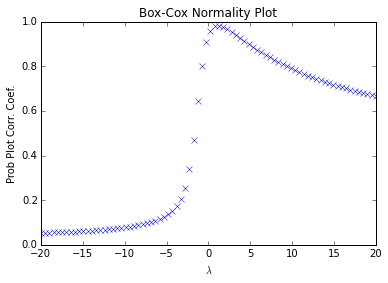

In [58]:
prob = stats.boxcox_normplot(subset_valence.dropna(), -20, 20, plot=plt)
prob

In [38]:
subset_valence = billboard_df_final[billboard_df_final["valence"] > 0]["valence"]
test_valence = subset_valence.dropna().map(lambda x: log(x))

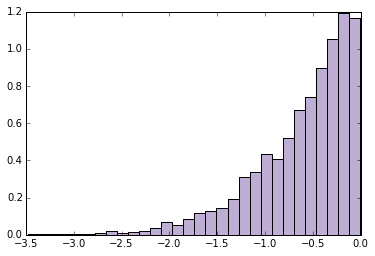

In [39]:
n, bins, patches = plt.hist(test_valence, normed = True, 
                            color = COLOR2, bins = 30)

In [59]:
boxcox, maxlog = stats.boxcox(subset_valence.dropna())
maxlog

1.0851936512647853

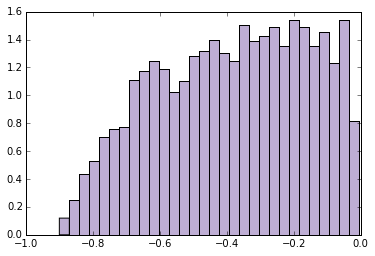

In [45]:
n, bins, patches = plt.hist(boxcox, normed = True, 
                            color = COLOR2, bins = 30)

In [46]:
subset_valence.head()

0    0.833641
1    0.158728
2    0.575020
3    0.815120
4    0.281412
Name: valence, dtype: float64